In [33]:
import pandas as pd
import numpy as np
import os
import GPy
import contextlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from SALib.sample import saltelli
from SALib.analyze import sobol

In [34]:
main_path = '../ExploreModularCirc'

# Select file
n_runs = 4096

# Read Input Data
df_x = pd.read_csv(f'{main_path}/Input/input_{n_runs}.csv')

# Select relevant inputs only
relevant_columns = []
for col in df_x.columns:
    relevant_columns.append(col)
    if col == 'T': break

# Select only first 5 inputs 
filtered_input = df_x[relevant_columns]

filtered_input

,# svn.c,pas.r,pas.c,pas.l,pat.r,pat.c,pat.l,pvn.r,pvn.c,ao.CQ,...,ti.CQ,rv.E_pas,rv.E_act,rv.v_ref,rv.k_pas,ra.E_pas,ra.E_act,ra.v_ref,ra.k_pas,T
0,27.687002,0.002863,0.155289,0.000045,0.306841,3.216036,0.001568,0.005335,14.078900,477.953026,...,524.214801,0.889745,2.067808,54.462362,0.013532,0.293514,0.265353,23.247156,0.027211,0.568772
1,19.583731,0.001892,0.216233,0.000076,0.970642,1.761023,0.002178,0.008813,21.074102,347.235884,...,256.323411,0.368834,0.647979,22.848745,0.027820,0.607115,0.225862,16.805634,0.015108,0.760948
2,11.151048,0.002357,0.116030,0.000035,0.960656,0.927419,0.001018,0.006478,29.982973,250.982182,...,437.947881,0.702951,1.336840,49.158198,0.022422,0.459658,0.165369,29.427299,0.022997,0.845690
3,23.578548,0.001390,0.232268,0.000054,0.552176,5.121283,0.002108,0.003369,17.822460,382.810481,...,380.042939,0.553660,2.745526,38.149745,0.016732,0.648015,0.314111,10.480856,0.014644,0.477865
4,21.266340,0.002222,0.184970,0.000062,0.677294,3.909687,0.001153,0.007160,26.330717,297.223537,...,491.995577,0.460890,3.375511,32.037828,0.017859,0.694387,0.155571,21.031370,0.028146,0.623831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,21.264687,0.001853,0.254570,0.000045,1.060595,4.217209,0.002331,0.008932,29.435792,308.157541,...,575.745513,0.948006,1.848299,24.057300,0.018128,0.412053,0.288476,19.288057,0.025811,0.787779
4092,23.576994,0.002506,0.207624,0.000048,1.185532,5.520820,0.001380,0.004585,20.006569,415.621822,...,290.042663,0.695323,1.400195,25.130137,0.017089,0.489675,0.243706,29.841049,0.011977,0.934979
4093,11.160247,0.001726,0.140698,0.000067,0.225051,1.233086,0.002417,0.008063,27.000518,196.296508,...,529.417665,0.561958,2.865017,57.246989,0.021529,0.676074,0.267086,10.272162,0.020351,0.462701
4094,19.585266,0.002027,0.246511,0.000032,0.624959,2.155471,0.001240,0.007228,23.096871,270.674227,...,372.794631,0.897181,2.172560,31.058883,0.028167,0.264965,0.343140,23.499831,0.017754,0.649567


In [35]:
# Load all sheets as a dictionary of DataFrames
sheets_dict = pd.read_excel(f"{main_path}/Outputs/Output_4096/combined_data.xlsx", sheet_name=None)

# Access individual DataFrames by sheet name
y_PC1 = sheets_dict['y_PC1']
y_PC2 = sheets_dict['y_PC2']
y_PC3 = sheets_dict['y_PC3']

CO = sheets_dict['cardiac_output']
max_press = sheets_dict['mean_pressure']


### Linear Emulator

In [72]:
# Example input and output data
X = filtered_input
Y = y_PC3

emulator_name = 'PC2'

# Initialize the model
linear_model = LinearRegression()

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Predict the output for the test data
y_pred = linear_model.predict(X_test)

# Compute R² score for the predictions versus actual test data
r2 = r2_score(y_test.iloc[:,0], y_pred)
# Output R² score
print("R² score:", r2)

R² score: 0.1450157842609484


### Sensitivty Analysis

In [73]:
## SaLib user inteerface
from SALib import ProblemSpec 

# Define a `dict` defining the number of inputs, the names of the inputs, and the bounds on each input:
problem = ProblemSpec({
    'num_vars': len(relevant_columns),
    'names': relevant_columns,
    'bounds' : filtered_input[relevant_columns].describe().loc[['min', 'max']].T.values,
    "outputs" : ["PC1"],
})

# Samples inputs
problem.sample_sobol(1024)
X_samples = problem.samples


# Import emulator to np array
beta_matrix = np.array(linear_model.coef_)
intercept = np.array(linear_model.intercept_)

# Ensure intercept has the correct shape
intercept = intercept.reshape(-1) 

# Dynamically determine the shape of Y based on X and beta_matrix
num_samples = X_samples.shape[0]  # Number of rows in X
num_outputs = beta_matrix.shape[0]  # Number of columns in beta_matrix


# Sample outputs 
Y = np.zeros((X_samples.shape[0], num_outputs))  # Initialize Y with the right shape

# Compute Y
for i in range(num_samples):
    Y[i] = beta_matrix @ X_samples[i,:] + intercept
    
# Set output and run analysis
problem.set_results(Y)


Samples:
	22 parameters: ['# svn.c', 'pas.r', 'pas.c', 'pas.l', 'pat.r', 'pat.c', 'pat.l', 'pvn.r', 'pvn.c', 'ao.CQ', 'mi.CQ', 'po.CQ', 'ti.CQ', 'rv.E_pas', 'rv.E_act', 'rv.v_ref', 'rv.k_pas', 'ra.E_pas', 'ra.E_act', 'ra.v_ref', 'ra.k_pas', 'T']
	47104 samples
Outputs:
	1 outputs: ['PC1']
	47104 evaluations


In [74]:
new = Y.reshape(-1)

 /opt/anaconda3/envs/ModularCirc/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning:unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


<Axes: >

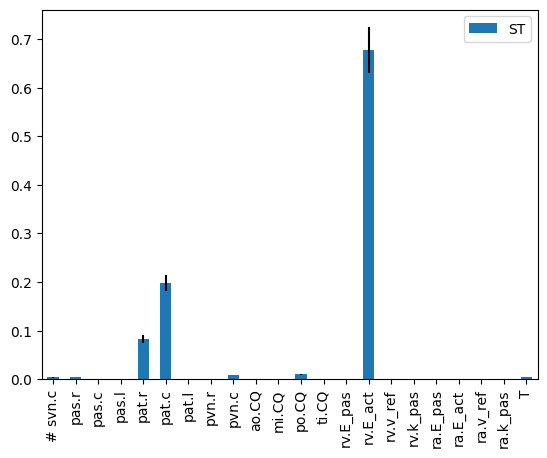

In [75]:
problem.set_results(new)
problem.analyze_sobol()

from SALib.plotting.bar import plot as barplot
Si = sobol.analyze(problem, new, print_to_console=False)
total, first, second = Si.to_df()
barplot(total)

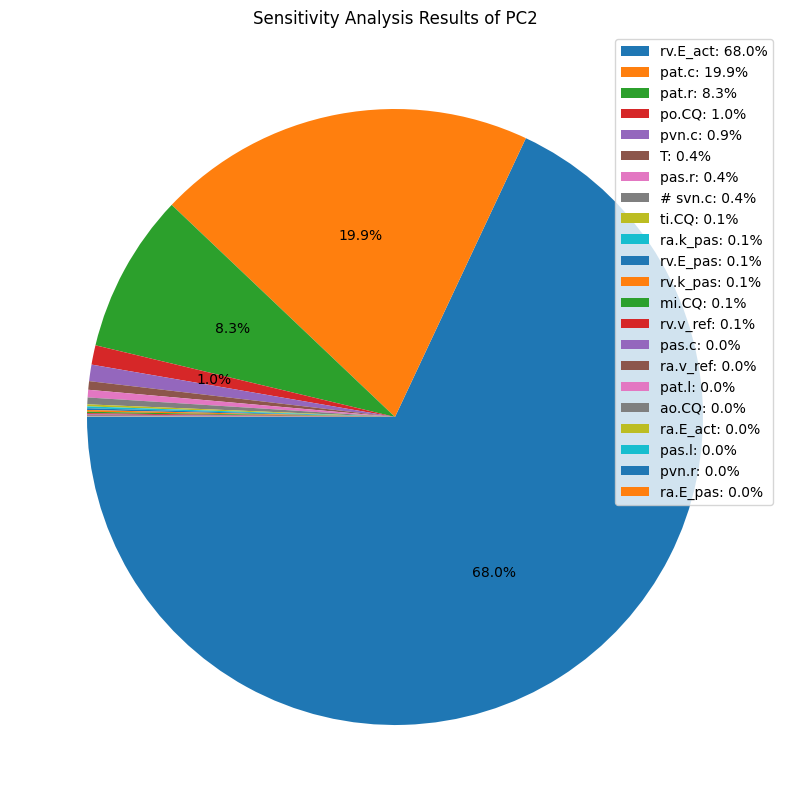

In [76]:
import matplotlib.pyplot as plt


# Sort the data in descending order of 'ST'
total.sort_values('ST', inplace=True, ascending=False)

# Assuming 'total' is a DataFrame with an index as labels and a column 'ST' for sizes
labels = total.index
sizes = total['ST']

# Create the pie chart
plt.figure(figsize=(15, 10))
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct=lambda pct: f'{pct:.1f}%' if pct >= 0.9 else '',  # Display percentages only if >= 1%
    startangle=180
)

# Add a title
plt.title(f'Sensitivity Analysis Results of {emulator_name}')

# Create a legend
# Include all labels in the legend regardless of their size
legend_labels = [f"{label}: {size / total['ST'].sum() * 100:.1f}%" for label, size in zip(labels, sizes)]
plt.legend(wedges, legend_labels, loc="best")

plt.show()